Background: This notebook is intended to illustrate the function to write a gmsh .geo-file that describes a fractured domain in 2D, runs gmsh, and then reads back the results.

# Import of external packages

We will define all points etc. as numpy arrays, as this seems the most convenient and general data format for whatever we will give to the filters later.

In [1]:
import numpy as np

Gmsh, like most other meshing packages, requires internal constraints to be non-intersecting. This means that, if the domain contains two fractures intersecting in a cross, gmsh likes to think of this as four lines, meeting in a central vertex. This splitting of lines can be handled by functions from the compgeom package.


In [2]:
from compgeom import basics

Plotting by matplotlib

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2

# Geometry of the domain, including compartments

We define the geometry of the entire domain, in terms of the max and min coordinates of x and y

In [5]:
domain = {'xmin': 0, 'xmax': 1, 'ymin': 0, 'ymax':2}

Define lines running through the domain. These will effectively split the domain into subdomains. The functionality is useful if the grid should conform to material discontinuities.

The lines are defined on the format ax + by = 1, where we provide the coefficients a and b as 2-by-n numpy array. To be fed to the gridding algorithm, the intersection between the compartment lines and the domain boundary must be computed. This is not difficult, but it is boring, and has so far not been necessary. Therefore,  **for the moment, we only consider lines in the x-direction, thus any y-component is ignored.** 

In [6]:
compartment_lines = np.array([[0.3, 0.5, 0.], # The x-component of the first line, together with the third line will be ignored
                              [0.,  1.5, .7]]) 

# Definition of internal constraints (fractures)

The next step is to define the fractures. The data format is a point coordinate array (Nd x num_points), together with connection information (2 x num_lines). Note that points can be shared by fractures (two fractures meeting in an L should be defined by three points, not four). Fractures may be intersecting; these lines will be split automatically later on.

We also define tags for all fractures, here illustrated by 1) a numbering of the fractures, and 2) a grouping of fractures.

In [7]:
frac_pts = np.array([[0.3, 0.5, 0.5, 0.3, 0.2, 0.8, 0.6, 0.6, 0.8],
                     [0.3, 0.3, 0.5, 0.5, 0.9, 1.9, 0.3, 0.5, 0.5]])

frac_con = np.array([[0, 2], [1, 3], [4, 5], [6, 7], [7, 8]]).T

# Two tags: One is a numbering, the other signifies fracture families (possibly from geological characterization)
frac_numbers = 1 + np.arange(frac_con.shape[1])
frac_families = np.array([1, 1, 2, 3, 1])
frac_tags = np.vstack((frac_numbers, frac_families))

frac_tag_explanation = {'Fracture number', 'Fracture familiy'}


Define a simple function to visualize the fractures we have defined.

In [8]:
def plot_fractures(d, p, c, colortag=None):
    """
    d: domain size in the form of a dictionary
    p - points
    c - connection between fractures
    colortag - indicate that fractures should have different colors
    """
    
    # Assign a color to each tag. We define these by RBG-values (simplest option in pyplot).
    # For the moment, some RBG values are hard coded, do something more intelligent if necessary.
    if colortag is None:
        tagmap = np.zeros(c.shape[1], dtype='int')
        col = [(0, 0, 0)];
    else:
        utag, tagmap = np.unique(colortag, return_inverse=True)
        ntag = utag.size
        if ntag <= 3:
            col = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]
        elif ntag < 6:
            col = [(1, 0, 0), (0, 1, 0), (0, 0, 1),
                   (1, 1, 0), (1, 0, 1), (0, 0, 1)]
        else:
            raise NotImplementedError('Have not thought of more than six colors')
    
    
    plt.figure()
    # Simple for-loop to draw one fracture after another. Not fancy, but it serves its purpose.
    for i in range(c.shape[1]):
        plt.plot([p[0, c[0, i]], p[0, c[1, i]]], [p[1, c[0, i]], p[1, c[1, i]]], 'o-',color=col[tagmap[i]])
    plt.axis([d['xmin'], d['xmax'], d['ymin'], d['ymax']])
    plt.show()

Plot the fractures, with coloring according to the fracture's respective families

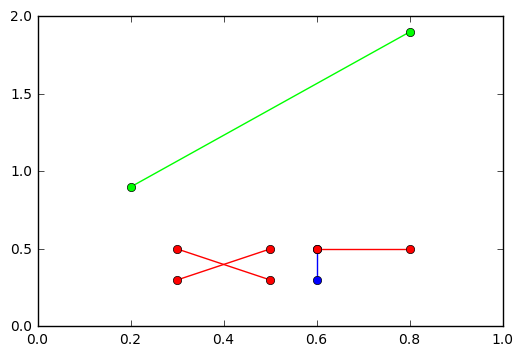

In [44]:
plot_fractures(domain, frac_pts, frac_con, frac_families)

# Split intersecting fractures

Before we write the input file to gmsh, the should be no intersections among the constraints. To that end, we first need to merge the fractures and the compartment lines. We also add an additional tag, telling whether the line is a fracture or a compartment.

In [10]:
class GmshConstants(object):
    """
    This class is a container for storing constant values that are used in 
    the meshing algorithm. The intention is to make them available to all
    functions and modules.
    
    This may not be the most pythonic way of doing this, but it works.
    """
    def __init__(self):
        self.DOMAIN_BOUNDARY_TAG = 1
        self.COMPARTMENT_BOUNDARY_TAG = 2
        self.FRACTURE_TAG = 3
        
        self.PHYSICAL_NAME_DOMAIN = 'DOMAIN'
        self.PHYSICAL_NAME_FRACTURES = 'FRACTURE_'

In [50]:
def merge_fracs_compartments_domain(dom, frac_p, frac_l, comp):
    
    
    constants = GmshConstants()
    
    # First create lines that define the domain
    x_min = dom['xmin']
    x_max = dom['xmax']
    y_min = dom['ymin']
    y_max = dom['ymax']
    dom_p = np.array([[x_min, x_max, x_max, x_min],
                      [y_min, y_min, y_max, y_max]])
    dom_lines = np.array([[0, 1], [1, 2], [2, 3], [3, 0]]).T
    
    num_dom_lines = dom_lines.shape[1] # Should be 4
    
    ## Then the compartments
    # First ignore compartment lines that have no y-component
    comp = np.squeeze(comp[:, np.argwhere(np.abs(comp[1]) > 1e-5)])
    
    num_comps = comp.shape[1]
    # Assume that the compartments are not intersecting at the boundary.
    # This may need revisiting when we allow for general lines (not only y=const)
    comp_p = np.zeros((2, num_comps * 2))
    
    for i in range(num_comps):
        # The line is defined as by=1, thus y = 1/b
        comp_p[:, 2*i : 2*(i+1)] = np.array([[x_min, x_max], 
                                            [1./comp[1, i], 1./comp[1, i]]])
    
    comp_lines = np.arange(2*num_comps, dtype='int').reshape((2, -1), order='F')
    
    # Neither domain nor compartments have tags, add this
    num_frac_tags = 1
    
    # The  lines will have all fracture-related tags set to zero. 
    # The plan is to ignore these tags for the boundary and compartments, so it should not matter
    dom_tags = constants.DOMAIN_BOUNDARY_TAG * np.ones((1, num_dom_lines))
    dom_l = np.vstack((dom_lines, dom_tags))
    comp_tags = constants.COMPARTMENT_BOUNDARY_TAG * np.ones((1, num_comps))
    comp_l = np.vstack((comp_lines, comp_tags))
    
    # Also add a tag to the fractures, signifying that these are fractures
    frac_l = np.vstack((frac_l, constants.FRACTURE_TAG * np.ones(frac_l.shape[1])))
    
    
    # Merge the point arrays, compartment points first
    p = np.hstack((dom_p, comp_p, frac_p))
    
    # Adjust index of compartment points to account for domain points in from of them
    comp_l[:2] += dom_p.shape[1]
    
    # Adjust index of fracture points to account for the compart points
    frac_l[:2] += dom_p.shape[1] + comp_p.shape[1]
    # 
    
    l = np.hstack((dom_l, comp_l, frac_l)).astype('int')
    
    # Add a second tag as an identifyer of each line
    l = np.vstack((l, np.arange(l.shape[1])))
    
    tag_description = ['Line type', 'Line number']
    
    return p, l, tag_description
    

Merge all lines, and plot the resulting network using the final tag to color the lines to verify that we can distinguish between domain boundary, compartment lines and fractures

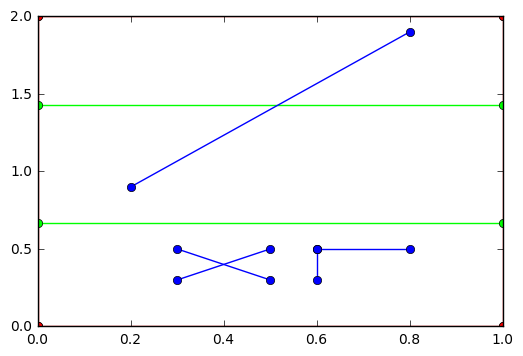

In [51]:
pts, lines, line_tag_description = merge_fracs_compartments_domain(domain, frac_pts, frac_con, compartment_lines)
plot_fractures(domain, pts, lines, lines[-2]) 

We are now ready to remove intersections between fractures

In [ ]:
dx = np.array([[domain['xmax'] - domain['xmin']], [domain['ymax'] - domain['ymin']]])
pts_split, lines_split = basics.remove_edge_crossings(pts, lines, dx)

# Plot the fractures again, with the line-type coloring. This should be equal to the previous one
plot_fractures(domain, pts_split, lines_split, lines_split[-2]) 

We are now finally in the position where gmsh can process the data. The next step is to write the .geo file

# Write the domain description to a GMSH .geo file

We define a class for the gmsh writer

In [14]:
def sort_point_pairs(lines, check_circular=True):
    """ Sort pairs of numbers to form a chain.
    
    The target application is to sort lines, defined by their 
    start end endpoints, so that they form a continuous polyline.
    
    The algorithm is brute-force, using a double for-loop. This can 
    surely be imporved.
    
    lines: np.ndarray, 2xn, the line pairs.
    check_circular: Verify that the sorted polyline form a circle.
                    Defaluts to true.
    """
    
    num_lines = lines.shape[1]
    sorted_lines = -np.ones((2, num_lines))
    
    # Start with the first line in input
    sorted_lines[:, 0] = lines[:, 0]
    
    # The starting point for the next line
    prev = sorted_lines[1, 0]
    
    # Keep track of which lines have been found, which are still candidates
    found = np.zeros(num_lines, dtype='bool')
    found[0] = True
    
    # The sorting algorithm: Loop over all places in sorted_line to be filled, 
    # for each of these, loop over all members in lines, check if the line is still
    # a candidate, and if one of its points equals the current starting point.
    # More efficient and more elegant approaches can surely be found, but this 
    # will do for now.
    for i in range(1, num_lines):  # The first line has already been found
        for j in range(0, num_lines):
            if not found[j] and lines[0, j] == prev:
                sorted_lines[:, i] = lines[:, j]
                found[j] = True
                prev = lines[1, i]
                break
            elif not found[j] and lines[1, j] == prev:
                sorted_lines[:, i] = lines[::-1, j]
                found[j] = True
                prev = lines[1, i]
                break
    # By now, we should have used all lines
    assert(np.all(found))
    if check_circular:
        assert sorted_lines[0, 0] == sorted_lines[1, -1]
    return sorted_lines

In [157]:
import tempfile

class GmshWriter(object):
    
    def __init__(self, pts, lines, file_name=None, nd=None):
        self.pts = pts
        self.lines = lines
        if nd is None:
            if pts.shape[0] == 2:
                self.nd = 2
            elif pts.shape[0] == 3:
                self.nd = 3
        else:
            self.nd = nd
        
        if file_name is None:
            fn = tempfile.mkstemp
#             self.geo_file = fn + '.geo'
        else:
            self.geo_file_name = file_name + '.geo'
    
    def write_geo(self, file_name):
        s = self.__write_points()
        
        if self.nd == 2:
            s += self.__write_boundary_2d()
            s += self.__write_fractures_compartments_2d()
        else:
            raise NotImplementedError('No 3D yet')
            
        with open(file_name, 'w') as f:
            f.write(s)
        
    def __write_fractures_compartments_2d(self):
        # Both fractures and compartments are 
        constants = GmshConstants()
        
        frac_ind = np.argwhere(np.logical_or(self.lines[2] == constants.COMPARTMENT_BOUNDARY_TAG, 
                                    self.lines[2] == constants.FRACTURE_TAG)).ravel()
        frac_lines = self.lines[:, frac_ind]
        
        s = '// Start specification of fractures \n'
        for i in range(frac_ind.size):
            s += 'frac_line_' + str(i) + ' = newl; Line(frac_line_' + str(i) + ') ={'
            s += 'p' + str(int(frac_lines[0, i])) + ', p' + str(int(frac_lines[1, i])) + '}; \n'
            s += 'Physical Line(\"' + constants.PHYSICAL_NAME_FRACTURES + str(i) + '\") = { frac_line_' + str(i) + ' };\n'
            s += 'Line{ frac_line_' + str(i) + '} In Surface{domain_surf}; \n' 
            
        s += '// End of fracture specification \n\n'
        return s
        
        
    def __write_boundary_2d(self):
        constants = GmshConstants()
        bound_line_ind = np.argwhere(self.lines[2] == constants.DOMAIN_BOUNDARY_TAG).ravel()
        bound_line = self.lines[:2, bound_line_ind]
        bound_line = sort_point_pairs(bound_line, check_circular=True)
        
        s = '// Start of specification of domain'
        s += '// Define lines that make up the domain boundary \n'
        
        loop_str = '{'
        for i in range(bound_line.shape[1]):
            s += 'bound_line_' + str(i) + ' = newl; Line(bound_line_' + str(i) + ') ={'
            s += 'p' + str(int(bound_line[0, i])) + ', p' + str(int(bound_line[1, i])) + '}; \n'
            loop_str += 'bound_line_' + str(i) + ', '
            
        s += '\n'
        loop_str = loop_str[:-2]  # Remove last comma
        loop_str += '}; \n'
        s += '// Line loop that makes the domain boundary \n'
        s += 'Domain_loop = newll; \n'
        s += 'Line Loop(Domain_loop) = ' + loop_str
        s += 'domain_surf = news; \n'
        s += 'Plane Surface(domain_surf) = {Domain_loop}; \n'
        s += 'Physical Surface(\"' + constants.PHYSICAL_NAME_DOMAIN + '\") = {domain_surf}; \n'
        s += '// End of domain specification \n \n'
        return s
    
    def __write_points(self):
        p = self.pts
        num_p = p.shape[1]
        if p.shape[0] == 2:
            p = np.vstack((p, np.zeros(num_p)))
        s = '// Define points \n'
        for i in range(self.pts.shape[1]):
            s += 'p' + str(i) + ' = newp; Point(p' + str(i) + ') = '
            s += '{' + str(p[0, i]) + ', ' + str(p[1, i]) + ', ' + str(p[2, i]) + ', 0.05};\n'
        s += '// End of point specification \n \n'
        return s
        
    

Define name of input and output file for gmsh. The input should have suffix .geo, the output .msh

In [16]:
in_file = 'gmsh_test.geo'
out_file = 'gmsh_test.msh'

In [158]:
gw = GmshWriter(pts_split, lines_split)
gw.write_geo(in_file)

# Create grid with gmsh

With the .geo-file written, the next step is to create a grid by gmsh. This part naturally requires access to gmsh, so you will need to change this to fit with your installation. 

The simplest option is probably to start gmsh, import the .geo-file, create a 2D grid, and save. This will also allow you to tweak the geometry or the mesh parameters, refine the grid and so on. All of this can of course be added to the .geo-file, but a look at the grid often helps in deciding what modifications to do.

The solution below runs gmsh from command line.

In [159]:
import sys, os

# Manually enter the path to gmsh; better options must surely exist
if sys.platform == 'windows' or sys.platform == 'win32':
    path_to_gmsh = 'C:\Users\Eirik\Dropbox\workspace\python\gridding\gmsh\gmsh_win_214'
else:
    path_to_gmsh = '/home/eke001/Dropbox/workspace/lib/gmsh/run/linux/gmsh'

# The -2 option tells gmsh to create a 2D grid
cmd = path_to_gmsh + ' -2 ' + in_file + ' -o ' + out_file

Gmsh can handle fairly large grids (hundreds of thousands of elements) in a matter of seconds, although it may require more time if the fracture geometry is complex relative to the desired grid resolution. Here, we run gmsh using os.system; there may be more appropriate ways of doing this.

In [160]:
status = os.system(cmd)

# Make sure we take note of whether gmsh did the job 
if status == 0:
    print('GMSH completed successfully')
else:
    print('Gmsh ran into problems')

GMSH completed successfully


# Read mesh info from file and identify fracture edges

Now that gmsh has created our mesh, we read it back into python. There are several python packages available that does the reading and parsing of a .msh file for us. We will use meshio, see https://pypi.python.org/pypi/meshio for details. 

meshio will give us all information needed for building the grid, but we still need to work a bit to identify edges that lies on individual fractures. Here, we use a slightly modified version of meshio.

In [161]:
from gridding.gmsh import mesh_io
points, cells, physnames, cell_info = mesh_io.read(out_file)
# gmsh works with 3D points, whereas we only need 2D
points = points[:, :2].transpose()

In [162]:
from core.grids import simplex
triangles = cells['triangle'].transpose()

# Construct grid
g = simplex.TriangleGrid(points, triangles)


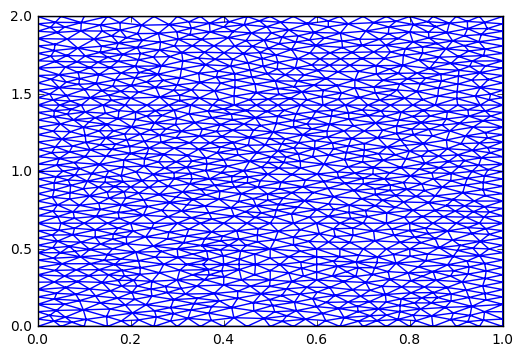

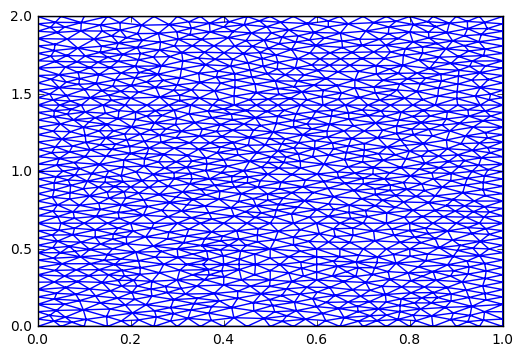

In [163]:
from viz import plot_grid
plot_grid.plot_grid(g)

In [201]:
def __match_face_fractures(cell_info, phys_names):
    # Match generated line cells (1D elements) with pre-defined fractures
    # via physical names.
    # Note that fracs and phys_names are both representation of the
    # fractures (after splitting due to intersections); fracs is the
    # information that goes into the gmsh algorithm (in the form of physical
    #  lines), while phys_names are those physical names generated in the
    # .msh file
    line_names = phys_names['line']

    # Tags of the cells, corrensponding to the physical entities (gmsh
    # terminology) are known to be in the first column
    cell_tags = cell_info['line'][:, 0]
    
    # Adjust the fracture tags so that the offset is the same as that provided by gmsh

    # Prepare array for tags. Assign nan values for faces an a starting
    # point, these should be overwritten later
    cell_2_frac = np.zeros(cell_tags.size)
    cell_2_frac[:] = np.nan

    # Loop over all physical lines, compare the tag of the cell with the tag
    # of the physical line.
    for iter1, name in enumerate(line_names):
        line_tag = name[1]
        frac_name = name[2]
        ind = frac_name.find('_')
        cell_2_frac[np.argwhere(cell_tags == line_tag)] = frac_name[ind+1:]

    # Sanity check, we should have asigned tags to all fracture faces by now
    assert np.all(np.isfinite(cell_2_frac))
    return cell_2_frac

In [203]:
frac_face_nodes = cells['line'].transpose()

# Nodes of faces in the grid
face_nodes = g.face_nodes.indices.reshape((2, g.num_faces), order='F').astype('int')


from utils import setmembership
ia, frac_ind = setmembership.ismember_rows(np.sort(frac_face_nodes, axis=0), np.sort(face_nodes, axis=0))

# Assign tags according to fracture faces
face_tags = np.zeros(g.num_faces)
face_tags[:] = None
face_tags[frac_ind] = line_2_frac

In [206]:
frac_face_tags = __match_face_fractures(cell_info, physnames).astype('int')


In [205]:
frac_num = np.ravel(lines_frac_face[1, np.argwhere(lines_frac_face[0] == 3)]) - sum(lines[2])

In [198]:
real_frac_ind = np.ravel(np.argwhere(lines_frac_face[0] == 3))

In [199]:
frac_ind

array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84])

[50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84]


In [193]:
lines[2]

array([1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3])